In [ ]:
! pip install tensorflow-gpu

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle && mv kaggle.json ~/.kaggle && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'adityajn105/flickr8k'

In [ ]:
! unzip '/content/flickr8k.zip'

# Image Captioning

In [12]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [25]:
# import dependencies
import pandas as pd
import numpy as np

import cv2

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model

In [26]:
caption_dict = {}
count=0
with open('captions.txt', 'r') as f:
  docs = f.read().split('\n')
  for row in docs[1:-1]:
    img = row.split(',')[0]
    cap = row.split(',')[1]
    cap = '<SOS> '+cap.strip()+' <EOS>'
    if img not in caption_dict:
      caption_dict[img]=[cap]
    else:
      caption_dict[img].append(cap)
    count +=1
    if count>=5000:
      break

In [8]:
len(caption_dict)

0

In [9]:
# create vocab...
vocab = {}
count=0
for img, captions in caption_dict.items():
  for sent in captions:
    for word in sent.split(' '):
      if word in vocab:
        pass
      else:
        count +=1
        vocab[word]=count


In [11]:
tf.keras.backend.clear_session()
res = ResNet50(include_top=True)
resnet = Model(inputs=res.input, outputs=res.layers[-2].output)



def img_preprocess(filepath):
  img = '/content/Images/'+filepath
  img = cv2.imread(img)
  img = cv2.resize(img, (224,224))
  img = img.reshape((1,224,224,3))
  img = tf.keras.applications.resnet50.preprocess_input(img)
  img = resnet.predict(img, verbose=0).reshape(2048)
  return img

102981632/102967424 [==============================] - 1s 0us/step


In [12]:
def sent_int(caption):
  caption = caption.split(' ')
  cap = []
  for word in caption:
    cap.append(vocab[word])
  return cap

In [13]:
# Dataset Generator

Img = []
Sent = []
output = []

for img, captions in caption_dict.items():
  img = img_preprocess(img)
  for caption in captions:
    caption = sent_int(caption)
    for i in range(1, len(caption)):
      try:
        out = to_categorical([caption[i]], num_classes=len(vocab))[0]
        sent = pad_sequences([caption[:i]], maxlen=40, padding='post', truncating='post')[0]
        Img.append(img)
        output.append(out)
        Sent.append(sent)
      except:
        pass


In [14]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [15]:
print('Img len : ',len(Img))
print('Sent len : ',len(Sent))
print('output len : ',len(output))

Img len :  62201
Sent len :  62201
output len :  62201


In [16]:
len(vocab)

3385

In [27]:
tf.keras.backend.clear_session()

max_len = 40
vocab_size = len(vocab)
embedding_size = 128

# image feature 
img_model = Sequential()
img_model.add(Dense(embedding_size, input_shape=( 2048,), activation='relu'))
img_model.add(RepeatVector(max_len))

# Text feature
sent_model = Sequential()
sent_model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_size, input_length=max_len, trainable=False))
sent_model.add(LSTM(256, return_sequences=True))
sent_model.add(TimeDistributed(Dense(128)))

# Concate feature
conca = Concatenate()([img_model.output, sent_model.output])
x = LSTM(embedding_size, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[img_model.input, sent_model.input], outputs = out)

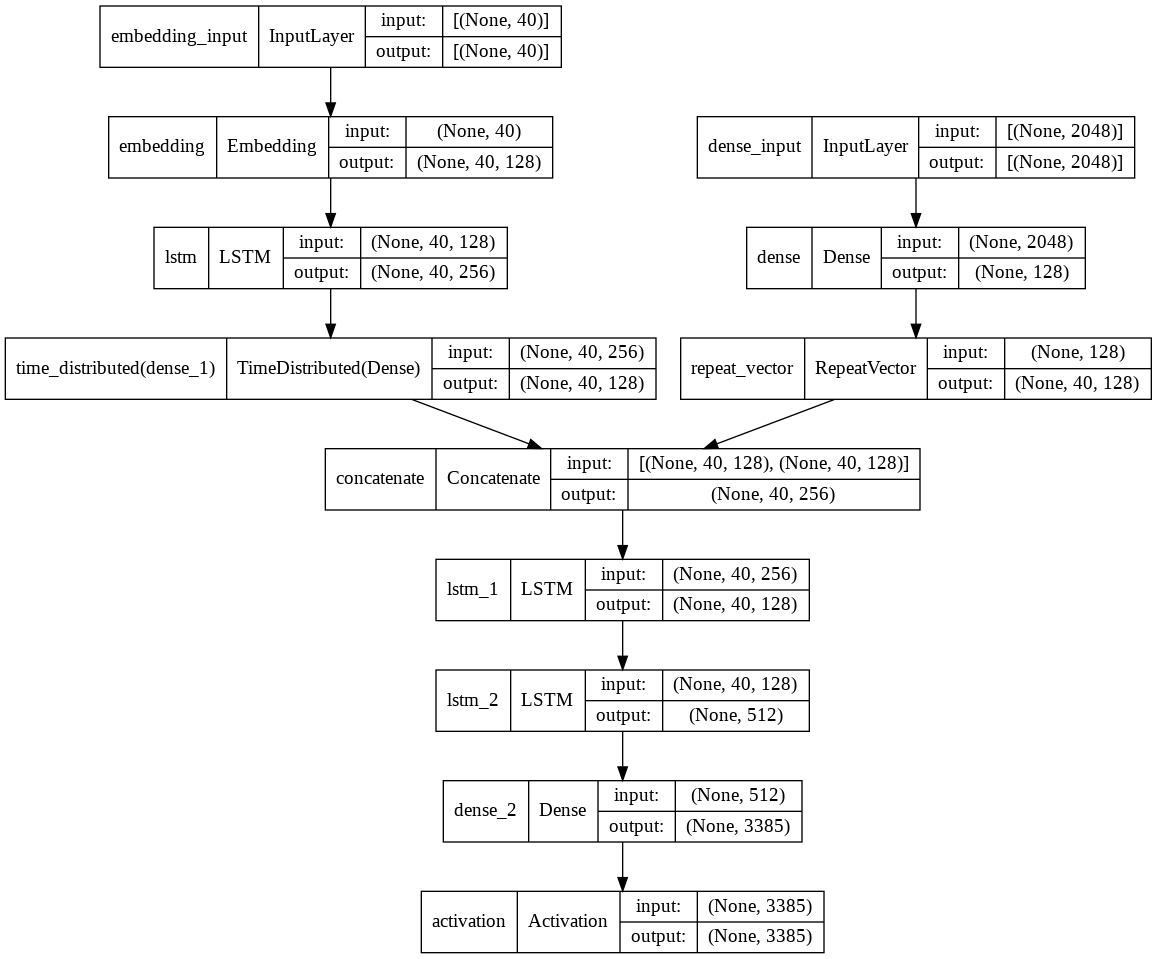

In [ ]:
plot_model(model, show_shapes=True)

In [18]:
Img = np.array(Img)

In [19]:
Sent  = np.array(Sent)

In [20]:
output = np.array(output)

In [22]:
np.save('/content/drive/MyDrive/Image Caption/Img.npy', Img)
np.save('/content/drive/MyDrive/Image Caption/Sent.npy', Sent)
np.save('/content/drive/MyDrive/Image Caption/output.npy', output)

In [4]:
Img = np.load('/content/drive/MyDrive/Image Caption/Img.npy')
Sent = np.load('/content/drive/MyDrive/Image Caption/Sent.npy')
output = np.load('/content/drive/MyDrive/Image Caption/output.npy')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.fit([Img, Sent], output, batch_size=32, epochs=50)

Epoch 1/50
1944/1944 [==============================] - 1726s 884ms/step - loss: 5.3350 - accuracy: 0.0811
Epoch 2/50
1017/1944 [==============>...............] - ETA: 13:25 - loss: 5.2024 - accuracy: 0.0941